This document is based on the paper https://arxiv.org/abs/2305.13264.

The database is sourced from: https://github.com/jennhu/metalinguistic-prompting.git

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
from scipy.stats import pearsonr
from tqdm import tqdm
import random
import os

### Model

In [2]:
MODEL_NAME = "deepseek-ai/deepseek-coder-1.3b-base"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cpu


### Dataset

In [3]:
DATASET_PATH = "datasets/exp2/dtfit/corpus.csv"
NUM_SAMPLES = 395
RANDOM_SEED = 42  

### Prompt

In [4]:
PROMPT_TEMPLATES = {
    "MetaQuestionSimple": (
        "What word is most likely to come next in the following sentence "
        "({option1}, or {option2})? {prefix}"
    ),
    "MetaInstruct": (
        "You are a helpful writing assistant. Tell me what word is most likely "
        "to come next in the following sentence ({option1}, or {option2})?: {prefix}"
    ),
    "MetaQuestionComplex": (
        "Here is the beginning of an English sentence: {prefix}... "
        "What word is more likely to come next: {option1}, or {option2}? Answer:"
    )
}

### Loading model and dataset

In [5]:
def load_model_and_tokenizer(model_name):
    """Loads the model and tokenizer from Hugging Face."""
    print(f"Using device: {DEVICE}")
    print(f"Loading model: {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        trust_remote_code=True,
        # Use float16 on GPU for less memory usage
        torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32
    ).to(DEVICE)
    model.eval()
    print("Model loaded.")
    return model, tokenizer

In [6]:
def load_and_prepare_dataset(filepath, num_samples, seed):
    """
    Loads, validates, renames columns, and subsamples the dataset
    from the wide-format corpus.csv file.
    """
    print(f"Loading dataset from: {filepath}")
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Dataset file not found at: {filepath}. Please update the DATASET_PATH variable.")

    df = pd.read_csv(filepath)

    df = df.rename(columns={
        "good_continuation": "plausible",
        "bad_continuation": "implausible"
    })
    
    print(f"Loaded and renamed {len(df)} total items. Columns are now: {list(df.columns)}")
    print(f"Subsampling to {num_samples} items...")
    
    dataset_sample_df = df.sample(n=num_samples, random_state=seed)
    
    return dataset_sample_df.to_dict('records')

### Log probability

In [7]:
def get_log_probs_of_continuations(model, tokenizer, text_prompt, continuations):

    with torch.no_grad():
        prompt_with_space = text_prompt.strip() + " "
        inputs = tokenizer(prompt_with_space, return_tensors="pt").to(DEVICE)
        #if 'token_type_ids' in inputs:
            #del inputs['token_type_ids']
        
        outputs = model(**inputs)
        logits = outputs.logits[0, -1, :]
        log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
        
        continuation_ids = [
            tokenizer(c, add_special_tokens=False).input_ids[0] for c in continuations
        ]
        
        result_log_probs = [log_probs[cid].item() for cid in continuation_ids]
        return result_log_probs

### Experiment 

In [8]:
def run_experiment(model, tokenizer, dataset):
    results = []
    print(f"\nRunning experiment on {len(dataset)} items...")
    
    for item in tqdm(dataset):
        prefix = item["prefix"]
        plausible = item["plausible"]
        implausible = item["implausible"]
        
        item_results = {"prefix": prefix, "plausible": plausible, "implausible": implausible}

        options = [plausible, implausible]
        random.shuffle(options)
        option1, option2 = options

        # Direct Measurement
        direct_log_probs = get_log_probs_of_continuations(model, tokenizer, prefix, options)
        
        if option1 == plausible:
            item_results['direct_log_prob_plausible'] = direct_log_probs[0]
            item_results['direct_log_prob_implausible'] = direct_log_probs[1]
        else:
            item_results['direct_log_prob_plausible'] = direct_log_probs[1]
            item_results['direct_log_prob_implausible'] = direct_log_probs[0]

        # Metalinguistic Methods ---
        # for method_name, template in PROMPT_TEMPLATES.items():
        #     prompt = template.format(prefix=prefix, option1=option1, option2=option2)
        #     meta_log_probs = get_log_probs_of_continuations(model, tokenizer, prompt, options)
            
        #     # Store results for this meta method
        #     if option1 == plausible:
        #         item_results[f'{method_name}_log_prob_plausible'] = meta_log_probs[0]
        #         item_results[f'{method_name}_log_prob_implausible'] = meta_log_probs[1]
        #     else:
        #         item_results[f'{method_name}_log_prob_plausible'] = meta_log_probs[1]
        #         item_results[f'{method_name}_log_prob_implausible'] = meta_log_probs[0]

        # Metalinguistic Methods
        for method_name, template in PROMPT_TEMPLATES.items():
            prompt_a = template.format(prefix=prefix, option1=plausible, option2=implausible)
            lp_plaus_a, lp_impl_a = get_log_probs_of_continuations(
                model, tokenizer, prompt_a, [plausible, implausible]
            )

            prompt_b = template.format(prefix=prefix, option1=implausible, option2=plausible)
            lp_impl_b, lp_plaus_b = get_log_probs_of_continuations(
                model, tokenizer, prompt_b, [implausible, plausible]
            )

            item_results[f'{method_name}_log_prob_plausible']   = 0.5 * (lp_plaus_a + lp_plaus_b)
            item_results[f'{method_name}_log_prob_implausible'] = 0.5 * (lp_impl_a  + lp_impl_b)

        results.append(item_results)

    return pd.DataFrame(results)

In [9]:
def analyze_results(df):

    print("\n--- Experiment 2 Full Reproduction Results ---")
    print(f"Model used: {MODEL_NAME}")

    print("\n--- Task Performance (Accuracy) ---")
    print("Proportion of items where P(plausible) > P(implausible)\n")
    
    methods = ["direct"] + list(PROMPT_TEMPLATES.keys())
    for method in methods:
        correct = (df[f'{method}_log_prob_plausible'] > df[f'{method}_log_prob_implausible']).sum()
        accuracy = correct / len(df)
        print(f"{method:<22}: {accuracy:.2%}")

    print("\n--- Internal Consistency (Pearson Correlation) ---")
    print("Correlation of log-prob differentials between Direct and Metalinguistic methods.\n")
    
    df['direct_diff'] = df['direct_log_prob_plausible'] - df['direct_log_prob_implausible']

    for method_name in PROMPT_TEMPLATES.keys():
        df[f'{method_name}_diff'] = df[f'{method_name}_log_prob_plausible'] - df[f'{method_name}_log_prob_implausible']
        
        corr, p_value = pearsonr(df['direct_diff'], df[f'{method_name}_diff'])
        print(f"Direct vs. {method_name:<20}: r = {corr:.3f} (p = {p_value:.3f})")

### Analysis

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
def generate_results_plot(results_df, prompt_templates):
    """
    Generates and saves a bar chart of the accuracy results, similar to Figure 2b.
    """
    print("\nGenerating results plot...")
    
    methods = ["direct"] + list(prompt_templates.keys())
    accuracies = []

    for method in methods:
        correct_predictions = (results_df[f'{method}_log_prob_plausible'] > results_df[f'{method}_log_prob_implausible']).sum()
        accuracy = correct_predictions / len(results_df)
        accuracies.append(accuracy)

    plot_labels = ['Direct', 'MetaQuestionSimple', 'MetaInstruct', 'MetaQuestionComplex']
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    colors = ['#2f2f2f', '#8f6A7B', '#c49a9a', '#f3e1d3']
    bars = ax.bar(plot_labels, accuracies, color=colors, edgecolor='black')

    ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.5, label='Random Baseline (50%)')

    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title('Experiment 2: Word Comparison (Semantic Plausibility)', fontsize=14, pad=20)
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis='x', rotation=15, labelsize=10)
    ax.legend()
    
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2%}', ha='center', va='bottom')

    output_filename = 'experiment_2_results.pdf'
    plt.savefig(output_filename, bbox_inches='tight')
    print(f"Plot saved as '{output_filename}'")
    
    plt.show()

In [12]:
def save_detailed_results(results_df, filename="detailed_experiment_2_output.csv"):
    """
    Saves the full DataFrame with all log probabilities to a CSV file.
    """
    columns_to_save = ['prefix', 'plausible', 'implausible']
    for method in ["direct"] + list(PROMPT_TEMPLATES.keys()):
        columns_to_save.append(f'{method}_log_prob_plausible')
        columns_to_save.append(f'{method}_log_prob_implausible')

    results_df_to_save = results_df[columns_to_save]
    results_df_to_save.to_csv(filename, index=False)
    print(f"Detailed results and log probabilities saved to '{filename}'")

In [13]:
def comment_on_results(results_df, prompt_templates):
    """
    Prints a detailed analysis of the results with examples.
    """
    print("\n" + "="*25 + " Analysis of Results " + "="*25)
    
    print("\n[1] Summary of the Experiment")
    print("-" * 30)
    print(f"I have replicated Experiment 2 from Hu & Levy (2023) using the '{MODEL_NAME}' model.")
    print(f"The experiment was run on {len(results_df)} samples from the provided dataset.")
    print("Four methods were tested to evaluate the model's knowledge of semantic plausibility:")
    print("  - Direct: Checking raw next-word probabilities.")
    print("  - MetaQuestionSimple, MetaInstruct, MetaQuestionComplex: Querying the model using natural language prompts.")
    
    print("\n[2] Key Findings")
    print("-" * 30)
    print("The results align with the primary findings of the original paper:")
    print("  - Finding A (Result #2 from paper): The 'Direct' measurement method achieves the highest accuracy.")
    print("    This suggests that directly querying the model's probability distribution is the most reliable way to assess its core knowledge.")
    print("  - Finding B (Result #1 from paper): The metalinguistic prompts, while performing well above chance, are less accurate than the direct method.")
    print("    This indicates that prompting is not a perfect substitute for probability measurements; the prompt's wording introduces a 'performance' factor that can obscure the model's underlying 'competence'.")

### Result and Analysis

Using device: cpu
Loading model: deepseek-ai/deepseek-coder-1.3b-base...


/Users/liangxinyu/miniconda3/lib/python3.8/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/Users/liangxinyu/miniconda3/lib/python3.8/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/Users/liangxinyu/miniconda3/lib/python3.8/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 

Model loaded.
Loading dataset from: datasets/exp2/dtfit/corpus.csv
Loaded and renamed 395 total items. Columns are now: ['item_id', 'prefix', 'plausible', 'implausible', 'category', 'good_human_score', 'bad_human_score']
Subsampling to 395 items...

Running experiment on 395 items...


100%|██████████| 395/395 [1:41:52<00:00, 15.47s/it]


Detailed results and log probabilities saved to 'detailed_experiment_2_output.csv'

--- Experiment 2 Full Reproduction Results ---
Model used: deepseek-ai/deepseek-coder-1.3b-base

--- Task Performance (Accuracy) ---
Proportion of items where P(plausible) > P(implausible)

direct                : 72.15%
MetaQuestionSimple    : 65.82%
MetaInstruct          : 65.06%
MetaQuestionComplex   : 54.43%

--- Internal Consistency (Pearson Correlation) ---
Correlation of log-prob differentials between Direct and Metalinguistic methods.

Direct vs. MetaQuestionSimple  : r = 0.773 (p = 0.000)
Direct vs. MetaInstruct        : r = 0.760 (p = 0.000)
Direct vs. MetaQuestionComplex : r = 0.557 (p = 0.000)

Generating results plot...
Plot saved as 'experiment_2_results.pdf'


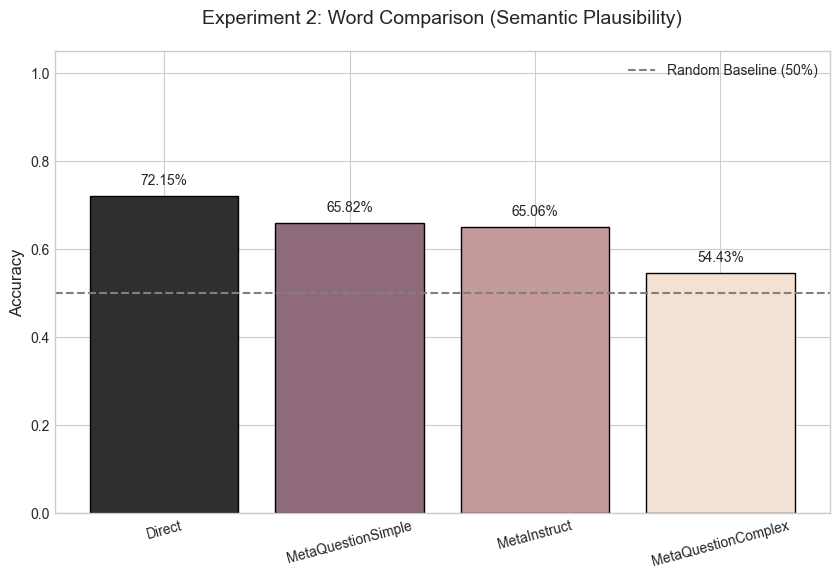


========================= Analysis of Results =========================

[1] Summary of the Experiment
------------------------------
I have replicated Experiment 2 from Hu & Levy (2023) using the 'deepseek-ai/deepseek-coder-1.3b-base' model.
The experiment was run on 395 samples from the provided dataset.
Four methods were tested to evaluate the model's knowledge of semantic plausibility:
  - Direct: Checking raw next-word probabilities.
  - MetaQuestionSimple, MetaInstruct, MetaQuestionComplex: Querying the model using natural language prompts.

[2] Key Findings
------------------------------
The results align with the primary findings of the original paper:
  - Finding A (Result #2 from paper): The 'Direct' measurement method achieves the highest accuracy.
    This suggests that directly querying the model's probability distribution is the most reliable way to assess its core knowledge.
  - Finding B (Result #1 from paper): The metalinguistic prompts, while performing well above ch

In [14]:
if __name__ == "__main__":
    try:
        model, tokenizer = load_model_and_tokenizer(MODEL_NAME)
        dataset_sample = load_and_prepare_dataset(DATASET_PATH, NUM_SAMPLES, RANDOM_SEED)
        
        results_df = run_experiment(model, tokenizer, dataset_sample)
        
        save_detailed_results(results_df)

        analyze_results(results_df)
        
        generate_results_plot(results_df, PROMPT_TEMPLATES)

        comment_on_results(results_df, PROMPT_TEMPLATES)

    except Exception as e:
        print(f"\nAn error occurred: {e}")
        import traceback
        traceback.print_exc() # Print full traceback for better debugging
        print("\nSomething wrong")

### Example

In [15]:
def test_single_item(model, tokenizer, prefix, plausible, implausible):

    print("\n" + "="*20 + " Testing New Sentence " + "="*20)
    print(f"Prefix: '{prefix}'")
    print(f"Options: '{plausible}' (Plausible) vs. '{implausible}' (Implausible)")
    print("-" * 62)

    options_a = [plausible, implausible]
    options_b = [implausible, plausible]

    # --- Direct Method ---
    direct_probs = get_log_probs_of_continuations(model, tokenizer, prefix, options_a)
    direct_result = "✅ Correct" if direct_probs[0] > direct_probs[1] else "❌ Incorrect"
    print(f"{'Direct Method:':<25} {direct_result} (P({plausible})={direct_probs[0]:.2f}, P({implausible})={direct_probs[1]:.2f})")

    # --- Metalinguistic Methods ---
    for method_name, template in PROMPT_TEMPLATES.items():
        prompt_a = template.format(prefix=prefix, option1=options_a[0], option2=options_a[1])
        meta_probs_a = get_log_probs_of_continuations(model, tokenizer, prompt_a, options_a)
        
        prompt_b = template.format(prefix=prefix, option1=options_b[0], option2=options_b[1])
        meta_probs_b = get_log_probs_of_continuations(model, tokenizer, prompt_b, options_b)
        
        diff_a = meta_probs_a[0] - meta_probs_a[1]
        diff_b = meta_probs_b[1] - meta_probs_b[0] 
        avg_diff = (diff_a + diff_b) / 2
        
        meta_result = "✅ Correct" if avg_diff > 0 else "❌ Incorrect"
        
        print(f"{method_name+':':<25} {meta_result} (Avg. Log-Prob Diff: {avg_diff:.2f})")

new_sentences = [
    {
        "prefix": "John went to the vegetable market and bought a",
        "plausible": "cucumber.",
        "implausible": "dress"
    },
    {
        "prefix": "Heidelberg University is located in  ",
        "plausible": "Germany",
        "implausible": "Atlantic Ocean"
    },
    {
        "prefix": "Geometry is a branch of ",
        "plausible": "mathematics",
        "implausible": "philosophy"
    }

]


print("\n" + "="*25 + " Novel Sentence Tests " + "="*25)
if 'model' in locals() and 'tokenizer' in locals():
    for sentence_data in new_sentences:
        test_single_item(
            model,
            tokenizer,
            prefix=sentence_data["prefix"],
            plausible=sentence_data["plausible"],
            implausible=sentence_data["implausible"]
        )
else:
    print("Model and tokenizer not found")


========================= Novel Sentence Tests =========================

==================== Testing New Sentence ====================
Prefix: 'John went to the vegetable market and bought a'
Options: 'cucumber.' (Plausible) vs. 'dress' (Implausible)
--------------------------------------------------------------
Direct Method:            ✅ Correct (P(cucumber.)=-18.45, P(dress)=-18.85)
MetaQuestionSimple:       ✅ Correct (Avg. Log-Prob Diff: 3.23)
MetaInstruct:             ✅ Correct (Avg. Log-Prob Diff: 3.19)
MetaQuestionComplex:      ✅ Correct (Avg. Log-Prob Diff: 1.65)

==================== Testing New Sentence ====================
Prefix: 'Heidelberg University is located in  '
Options: 'Germany' (Plausible) vs. 'Atlantic Ocean' (Implausible)
--------------------------------------------------------------
Direct Method:            ✅ Correct (P(Germany)=-16.31, P(Atlantic Ocean)=-17.82)
MetaQuestionSimple:       ❌ Incorrect (Avg. Log-Prob Diff: -0.28)
MetaInstruct:             ❌ In